# Crytocurrency price forecasting using Neural Networks

In [1]:
#! pip install optuna

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import optuna

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score as R_squared
from sklearn.metrics import explained_variance_score as EVS

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from collections import OrderedDict

# We do this to ignore several specific Pandas warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
data_path = 'D:/USMS/UChicago/STUDIES/Autumn 2020/MSCA 31009 2 Machine Learning & Predictive Analytics/Final Project/data/'

In [4]:
# importing the data
BTC_USD = pd.read_csv(data_path+'BTC-USD.csv')
BTC_USD.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,23-11-15,324.350006,325.118011,321.290009,323.045990,323.045990,27478900
1,24-11-15,323.014008,323.058014,318.118011,320.045990,320.045990,29362600
2,25-11-15,320.045013,329.134003,316.769989,328.205994,328.205994,41666900
3,26-11-15,328.303009,366.756989,328.229004,352.683990,352.683990,106105000
4,27-11-15,351.860992,363.588989,347.869995,358.041992,358.041992,55179100


In [5]:
# importing the data
XRP_USD = pd.read_csv(data_path+'XRP-USD.csv')
XRP_USD.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-11-23,0.004269,0.004351,0.004237,0.004288,0.004288,314451
1,2015-11-24,0.004288,0.004288,0.004201,0.004242,0.004242,197940
2,2015-11-25,0.004242,0.004325,0.004228,0.004318,0.004318,197356
3,2015-11-26,0.004317,0.004435,0.004227,0.004291,0.004291,400520
4,2015-11-27,0.004276,0.004304,0.004229,0.004276,0.004276,199790


In [6]:
# importing the data
ETH_USD = pd.read_csv(data_path+'ETH-USD.csv')
ETH_USD.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-11-26,0.863273,0.903643,0.804360,0.884183,0.884183,947473
1,2015-11-27,0.882100,0.900051,0.860695,0.867951,0.867951,403813
2,2015-11-28,0.868102,0.929293,0.862122,0.915703,0.915703,462464
3,2015-11-29,0.914144,0.914153,0.860533,0.878614,0.878614,448358
4,2015-11-30,0.879951,0.895054,0.847696,0.873119,0.873119,784439


Visualizing the data

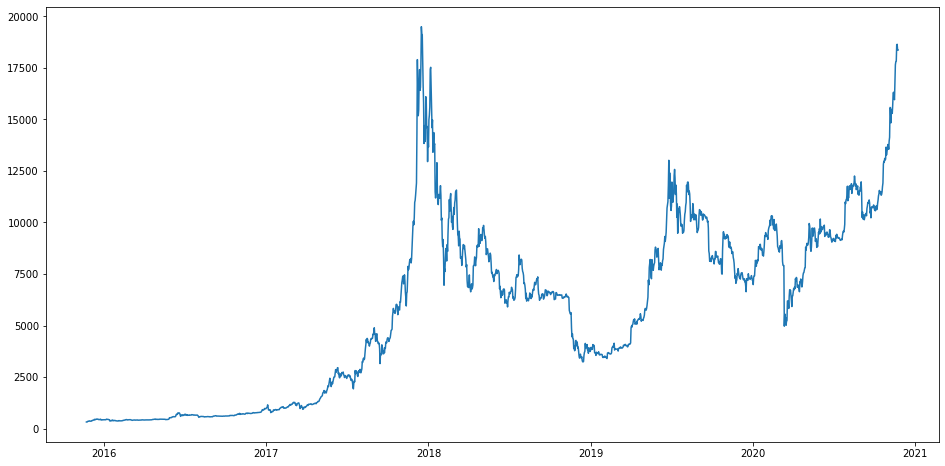

In [7]:
#setting index as date
BTC_USD['Date'] = pd.to_datetime(BTC_USD.Date,format='%d-%m-%y')
BTC_USD.index = BTC_USD['Date']

#plot
plt.figure(figsize=(16,8))
plt.plot(BTC_USD['Adj Close'], label='Close Price history')
plt.show()

Linear Regression is not designed to capture the short term dynamics or the autocorrelations which are present in this sequential data. It is more designed to look at the data globally and capture the global trend. We need a model that is able to capture the short term dynamics and short term dependencies within our dataset.

In the world of Neural Networks, we have something called **Recurrent Neural Networks** which is designed to capture these dependencies. Let's apply this and see how it performs in predicting the Bitcoin prices

In [8]:
BTC_USD.head()

,Date,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,,
2015-11-23,2015-11-23,324.350006,325.118011,321.290009,323.045990,323.045990,27478900
2015-11-24,2015-11-24,323.014008,323.058014,318.118011,320.045990,320.045990,29362600
2015-11-25,2015-11-25,320.045013,329.134003,316.769989,328.205994,328.205994,41666900
2015-11-26,2015-11-26,328.303009,366.756989,328.229004,352.683990,352.683990,106105000
2015-11-27,2015-11-27,351.860992,363.588989,347.869995,358.041992,358.041992,55179100


In [9]:
BTC_USD.reset_index(drop=True,inplace=True)

In [10]:
BTC_USD.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-11-23,324.350006,325.118011,321.290009,323.045990,323.045990,27478900
1,2015-11-24,323.014008,323.058014,318.118011,320.045990,320.045990,29362600
2,2015-11-25,320.045013,329.134003,316.769989,328.205994,328.205994,41666900
3,2015-11-26,328.303009,366.756989,328.229004,352.683990,352.683990,106105000
4,2015-11-27,351.860992,363.588989,347.869995,358.041992,358.041992,55179100


In [11]:
BTC_USD.shape

(1828, 7)

### Making the data ready for feeding to the RNNs

In [12]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [13]:
# fix random seed for reproducibility
np.random.seed(5)

In [14]:
# take adjusted close price column
bitcoin_y = BTC_USD['Adj Close'].values
bitcoin_dataset=bitcoin_y.reshape(-1, 1)

In [15]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
bitcoin_dataset = scaler.fit_transform(bitcoin_dataset)

In [16]:
# split into train and test sets, 25% test data, 75% training data
bitcoin_train_size = int(len(bitcoin_dataset) * 0.75)
bitcoin_test_size = len(bitcoin_dataset) - bitcoin_train_size
bitcoin_train, bitcoin_test = bitcoin_dataset[0:bitcoin_train_size,:], bitcoin_dataset[bitcoin_train_size:len(bitcoin_dataset),:]

In [17]:
# reshape into X=t and Y=t+1, timestep 240
look_back = 240
bitcoin_trainX, bitcoin_trainY = create_dataset(bitcoin_train, look_back)
bitcoin_testX, bitcoin_testY = create_dataset(bitcoin_test, look_back)

In [18]:
# reshape input to be [samples, time steps, features]
bitcoin_trainX = np.reshape(bitcoin_trainX, (bitcoin_trainX.shape[0], 1, bitcoin_trainX.shape[1]))
bitcoin_testX = np.reshape(bitcoin_testX, (bitcoin_testX.shape[0], 1, bitcoin_testX.shape[1]))

### Simple RNN

In [19]:
# using 10 epochs
model_RNN = Sequential()
model_RNN.add(SimpleRNN(1,activation = 'relu'))
model_RNN.add(Dense(1,activation = 'relu'))
model_RNN.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
model_RNN.fit(bitcoin_trainX, bitcoin_trainY, epochs=10, batch_size=240, verbose=1)

Epoch 1/10
5/5 [==============================] - ETA: 0s - loss: 0.1105 - mean_squared_error: 0.11 - 0s 10ms/step - loss: 0.1063 - mean_squared_error: 0.1063
Epoch 2/10
5/5 [==============================] - ETA: 0s - loss: 0.1247 - mean_squared_error: 0.12 - 0s 3ms/step - loss: 0.1063 - mean_squared_error: 0.1063
Epoch 3/10
5/5 [==============================] - ETA: 0s - loss: 0.1130 - mean_squared_error: 0.11 - 0s 4ms/step - loss: 0.1063 - mean_squared_error: 0.1063
Epoch 4/10
5/5 [==============================] - ETA: 0s - loss: 0.0976 - mean_squared_error: 0.09 - 0s 4ms/step - loss: 0.1063 - mean_squared_error: 0.1063
Epoch 5/10
5/5 [==============================] - ETA: 0s - loss: 0.1182 - mean_squared_error: 0.11 - 0s 3ms/step - loss: 0.1063 - mean_squared_error: 0.1063
Epoch 6/10
5/5 [==============================] - ETA: 0s - loss: 0.1142 - mean_squared_error: 0.11 - 0s 4ms/step - loss: 0.1063 - mean_squared_error: 0.1063
Epoch 7/10
5/5 [==============================] - E

In [20]:
# make predictions
bitcoin_trainPredict_RNN = model_RNN.predict(bitcoin_trainX)
bitcoin_testPredict_RNN = model_RNN.predict(bitcoin_testX)

In [21]:
# calculate root mean squared error
bitcoin_trainScore = np.sqrt(MSE(bitcoin_trainY, bitcoin_trainPredict_RNN))
print('Train RMSE for the bitcoin LSTM: %.2f' % (bitcoin_trainScore))
bitcoin_testScore = np.sqrt(MSE(bitcoin_testY, bitcoin_testPredict_RNN))
print('Test RMSE for the bitcoin LSTM: %.2f' % (bitcoin_testScore))

Train RMSE for the bitcoin LSTM: 0.33
Test RMSE for the bitcoin LSTM: 0.56


We see that using 10 epochs resulted in not so good predictions as the model was not able to learn properly, it is underfitting. The accuracy is very low as well. Let's try with more epochs

In [22]:
# using 100 epochs
model_RNN = Sequential()
model_RNN.add(SimpleRNN(1,activation = 'relu'))
model_RNN.add(Dense(1,activation = 'relu'))
model_RNN.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
model_RNN.fit(bitcoin_trainX, bitcoin_trainY, epochs=100, batch_size=240, verbose=1)

Epoch 1/100
5/5 [==============================] - ETA: 0s - loss: 0.0959 - mean_squared_error: 0.09 - 0s 4ms/step - loss: 0.1063 - mean_squared_error: 0.1063
Epoch 2/100
5/5 [==============================] - ETA: 0s - loss: 0.0995 - mean_squared_error: 0.09 - 0s 4ms/step - loss: 0.1063 - mean_squared_error: 0.1063
Epoch 3/100
5/5 [==============================] - ETA: 0s - loss: 0.1041 - mean_squared_error: 0.10 - 0s 3ms/step - loss: 0.1063 - mean_squared_error: 0.1063
Epoch 4/100
5/5 [==============================] - ETA: 0s - loss: 0.1080 - mean_squared_error: 0.10 - 0s 5ms/step - loss: 0.1063 - mean_squared_error: 0.1063
Epoch 5/100
5/5 [==============================] - ETA: 0s - loss: 0.1046 - mean_squared_error: 0.10 - 0s 5ms/step - loss: 0.1063 - mean_squared_error: 0.1063
Epoch 6/100
5/5 [==============================] - ETA: 0s - loss: 0.0948 - mean_squared_error: 0.09 - 0s 4ms/step - loss: 0.1063 - mean_squared_error: 0.1063
Epoch 7/100
5/5 [=============================

5/5 [==============================] - ETA: 0s - loss: 0.1063 - mean_squared_error: 0.10 - 0s 4ms/step - loss: 0.1063 - mean_squared_error: 0.1063
Epoch 53/100
5/5 [==============================] - ETA: 0s - loss: 0.1057 - mean_squared_error: 0.10 - 0s 3ms/step - loss: 0.1063 - mean_squared_error: 0.1063
Epoch 54/100
5/5 [==============================] - ETA: 0s - loss: 0.1063 - mean_squared_error: 0.10 - 0s 3ms/step - loss: 0.1063 - mean_squared_error: 0.1063
Epoch 55/100
5/5 [==============================] - ETA: 0s - loss: 0.0984 - mean_squared_error: 0.09 - 0s 4ms/step - loss: 0.1063 - mean_squared_error: 0.1063
Epoch 56/100
5/5 [==============================] - ETA: 0s - loss: 0.1034 - mean_squared_error: 0.10 - 0s 4ms/step - loss: 0.1063 - mean_squared_error: 0.1063
Epoch 57/100
5/5 [==============================] - ETA: 0s - loss: 0.1034 - mean_squared_error: 0.10 - 0s 3ms/step - loss: 0.1063 - mean_squared_error: 0.1063
Epoch 58/100
5/5 [==============================] - E

In [23]:
# make predictions
bitcoin_trainPredict_RNN = model_RNN.predict(bitcoin_trainX)
bitcoin_testPredict_RNN = model_RNN.predict(bitcoin_testX)

In [24]:
# calculate root mean squared error
bitcoin_trainScore = np.sqrt(MSE(bitcoin_trainY, bitcoin_trainPredict_RNN))
print('Train RMSE for the bitcoin LSTM: %.2f' % (bitcoin_trainScore))
bitcoin_testScore = np.sqrt(MSE(bitcoin_testY, bitcoin_testPredict_RNN))
print('Test RMSE for the bitcoin LSTM: %.2f' % (bitcoin_testScore))

Train RMSE for the bitcoin LSTM: 0.33
Test RMSE for the bitcoin LSTM: 0.56


We now see that even after increasing the number of epochs, the performance of the simple RNN model did not improve. This shows that simple RNN was not able to capture the systematic patterns that we have in our data. Also, as in simple RNN, there is paramater sharing across the layers, there is **Vanishing Gradient Problem**. The neurons are not learning beyond a certain point as the weights have stopped updating due to this Vanishing Gradient Problem.

So, in order to solve this problem, we can use **LSTM (Long Short Term Memory)**

### LSTM - Long Short Term Memory

In [28]:
# create and fit the LSTM network, optimizer=adam, 25 neurons, dropout 0.1
bitcoin_lstm_model = Sequential()
bitcoin_lstm_model.add(LSTM(25, input_shape=(1, look_back)))
bitcoin_lstm_model.add(Dropout(0.1))
bitcoin_lstm_model.add(Dense(1))
bitcoin_lstm_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
bitcoin_lstm_model.fit(bitcoin_trainX, bitcoin_trainY, epochs=100, batch_size=240, verbose=1)

Epoch 1/100
5/5 [==============================] - ETA: 0s - loss: 0.0424 - mean_squared_error: 0.04 - ETA: 0s - loss: 0.0315 - mean_squared_error: 0.03 - 0s 15ms/step - loss: 0.0315 - mean_squared_error: 0.0315
Epoch 2/100
5/5 [==============================] - ETA: 0s - loss: 0.0187 - mean_squared_error: 0.01 - 0s 5ms/step - loss: 0.0127 - mean_squared_error: 0.0127
Epoch 3/100
5/5 [==============================] - ETA: 0s - loss: 0.0127 - mean_squared_error: 0.01 - 0s 4ms/step - loss: 0.0096 - mean_squared_error: 0.0096
Epoch 4/100
5/5 [==============================] - ETA: 0s - loss: 0.0103 - mean_squared_error: 0.01 - 0s 4ms/step - loss: 0.0089 - mean_squared_error: 0.0089
Epoch 5/100
5/5 [==============================] - ETA: 0s - loss: 0.0093 - mean_squared_error: 0.00 - 0s 6ms/step - loss: 0.0076 - mean_squared_error: 0.0076
Epoch 6/100
5/5 [==============================] - ETA: 0s - loss: 0.0069 - mean_squared_error: 0.00 - 0s 5ms/step - loss: 0.0061 - mean_squared_error: 

Epoch 52/100
5/5 [==============================] - ETA: 0s - loss: 0.0014 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0015 - mean_squared_error: 0.0015
Epoch 53/100
5/5 [==============================] - ETA: 0s - loss: 0.0013 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0015 - mean_squared_error: 0.0015
Epoch 54/100
5/5 [==============================] - ETA: 0s - loss: 0.0015 - mean_squared_error: 0.00 - 0s 5ms/step - loss: 0.0016 - mean_squared_error: 0.0016
Epoch 55/100
5/5 [==============================] - ETA: 0s - loss: 0.0020 - mean_squared_error: 0.00 - 0s 5ms/step - loss: 0.0017 - mean_squared_error: 0.0017
Epoch 56/100
5/5 [==============================] - ETA: 0s - loss: 0.0013 - mean_squared_error: 0.00 - 0s 5ms/step - loss: 0.0015 - mean_squared_error: 0.0015
Epoch 57/100
5/5 [==============================] - ETA: 0s - loss: 0.0019 - mean_squared_error: 0.00 - 0s 5ms/step - loss: 0.0015 - mean_squared_error: 0.0015
Epoch 58/100
5/5 [======================

In [29]:
# make predictions
bitcoin_trainPredict = bitcoin_lstm_model.predict(bitcoin_trainX)
bitcoin_testPredict = bitcoin_lstm_model.predict(bitcoin_testX)

In [30]:
# calculate root mean squared error
bitcoin_trainScore = np.sqrt(MSE(bitcoin_trainY, bitcoin_trainPredict))
print('Train RMSE for the bitcoin LSTM: %.2f' % (bitcoin_trainScore))
bitcoin_testScore = np.sqrt(MSE(bitcoin_testY, bitcoin_testPredict))
print('Test RMSE for the bitcoin LSTM: %.2f' % (bitcoin_testScore))

Train RMSE for the bitcoin LSTM: 0.03
Test RMSE for the bitcoin LSTM: 0.05


So, using LSTM we have seen **marked improvement** in the performance of the model and it is now making much **better predictions**.

In [31]:
# invert predictions
bitcoin_trainPredict_reverted = scaler.inverse_transform(bitcoin_trainPredict)
bitcoin_trainY_reverted = scaler.inverse_transform([bitcoin_trainY])
bitcoin_testPredict_reverted = scaler.inverse_transform(bitcoin_testPredict)
bitcoin_testY_reverted = scaler.inverse_transform([bitcoin_testY])

In [32]:
# shift train predictions for plotting
bitcoin_trainPredictPlot = np.empty_like(bitcoin_dataset)
bitcoin_trainPredictPlot[:, :] = np.nan
bitcoin_trainPredictPlot[look_back:len(bitcoin_trainPredict_reverted)+look_back, :] = bitcoin_trainPredict_reverted

In [33]:
# shift test predictions for plotting
bitcoin_testPredictPlot = np.empty_like(bitcoin_dataset)
bitcoin_testPredictPlot[:, :] = np.nan
bitcoin_testPredictPlot[len(bitcoin_trainPredict_reverted)+(look_back*2)+1:len(bitcoin_dataset)-1, :] = bitcoin_testPredict_reverted

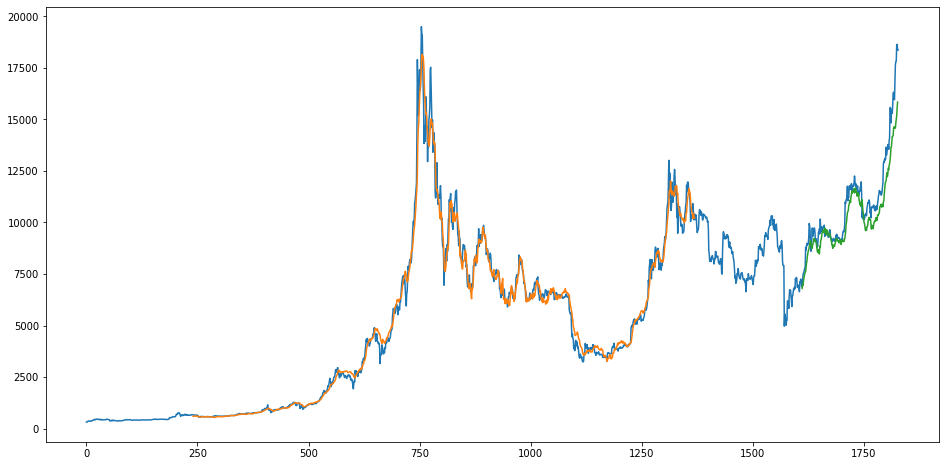

In [34]:
# plot baseline and predictions
plt.figure(figsize=(16,8))
plt.plot(scaler.inverse_transform(bitcoin_dataset))
plt.plot(bitcoin_trainPredictPlot)
plt.plot(bitcoin_testPredictPlot)

Now, let's try using a different optimizer - **Stochastic Gradient Descent** for LSTM

In [35]:
# create and fit the LSTM network, optimizer=SGD, 25 neurons, dropout 0.1
bitcoin_lstm_model = Sequential()
bitcoin_lstm_model.add(LSTM(25, input_shape=(1, look_back)))
bitcoin_lstm_model.add(Dropout(0.1))
bitcoin_lstm_model.add(Dense(1))
bitcoin_lstm_model.compile(loss='mean_squared_error', optimizer='SGD',metrics=['mean_squared_error'])
bitcoin_lstm_model.fit(bitcoin_trainX, bitcoin_trainY, epochs=10, batch_size=240, verbose=1)

Epoch 1/10
5/5 [==============================] - ETA: 0s - loss: 0.1677 - mean_squared_error: 0.16 - 0s 6ms/step - loss: 0.1371 - mean_squared_error: 0.1371
Epoch 2/10
5/5 [==============================] - ETA: 0s - loss: 0.0967 - mean_squared_error: 0.09 - 0s 5ms/step - loss: 0.0745 - mean_squared_error: 0.0745
Epoch 3/10
5/5 [==============================] - ETA: 0s - loss: 0.0542 - mean_squared_error: 0.05 - 0s 5ms/step - loss: 0.0449 - mean_squared_error: 0.0449
Epoch 4/10
5/5 [==============================] - ETA: 0s - loss: 0.0350 - mean_squared_error: 0.03 - 0s 4ms/step - loss: 0.0283 - mean_squared_error: 0.0283
Epoch 5/10
5/5 [==============================] - ETA: 0s - loss: 0.0244 - mean_squared_error: 0.02 - 0s 5ms/step - loss: 0.0208 - mean_squared_error: 0.0208
Epoch 6/10
5/5 [==============================] - ETA: 0s - loss: 0.0197 - mean_squared_error: 0.01 - 0s 5ms/step - loss: 0.0174 - mean_squared_error: 0.0174
Epoch 7/10
5/5 [==============================] - ET

In [36]:
# make predictions
bitcoin_trainPredict = bitcoin_lstm_model.predict(bitcoin_trainX)
bitcoin_testPredict = bitcoin_lstm_model.predict(bitcoin_testX)

In [37]:
# calculate root mean squared error
bitcoin_trainScore = np.sqrt(MSE(bitcoin_trainY, bitcoin_trainPredict))
print('Train RMSE for the bitcoin LSTM: %.2f' % (bitcoin_trainScore))
bitcoin_testScore = np.sqrt(MSE(bitcoin_testY, bitcoin_testPredict))
print('Test RMSE for the bitcoin LSTM: %.2f' % (bitcoin_testScore))

Train RMSE for the bitcoin LSTM: 0.10
Test RMSE for the bitcoin LSTM: 0.15


We see **Stochastic Gradient Descent** is not that effective as **ADAM** when it comes to optimizing the cost function

Using a different optimizer - **AdaGrad**

In [38]:
# create and fit the LSTM network, optimizer=SGD, 25 neurons, dropout 0.1
bitcoin_lstm_model = Sequential()
bitcoin_lstm_model.add(LSTM(25, input_shape=(1, look_back)))
bitcoin_lstm_model.add(Dropout(0.1))
bitcoin_lstm_model.add(Dense(1))
bitcoin_lstm_model.compile(loss='mean_squared_error', optimizer='Adagrad',metrics=['mean_squared_error'])
bitcoin_lstm_model.fit(bitcoin_trainX, bitcoin_trainY, epochs=10, batch_size=240, verbose=1)

Epoch 1/10
5/5 [==============================] - ETA: 0s - loss: 0.0866 - mean_squared_error: 0.08 - 0s 6ms/step - loss: 0.0860 - mean_squared_error: 0.0860
Epoch 2/10
5/5 [==============================] - ETA: 0s - loss: 0.0818 - mean_squared_error: 0.08 - 0s 6ms/step - loss: 0.0754 - mean_squared_error: 0.0754
Epoch 3/10
5/5 [==============================] - ETA: 0s - loss: 0.0647 - mean_squared_error: 0.06 - 0s 5ms/step - loss: 0.0667 - mean_squared_error: 0.0667
Epoch 4/10
5/5 [==============================] - ETA: 0s - loss: 0.0649 - mean_squared_error: 0.06 - 0s 5ms/step - loss: 0.0590 - mean_squared_error: 0.0590
Epoch 5/10
5/5 [==============================] - ETA: 0s - loss: 0.0586 - mean_squared_error: 0.05 - 0s 9ms/step - loss: 0.0532 - mean_squared_error: 0.0532
Epoch 6/10
5/5 [==============================] - ETA: 0s - loss: 0.0551 - mean_squared_error: 0.05 - 0s 5ms/step - loss: 0.0479 - mean_squared_error: 0.0479
Epoch 7/10
5/5 [==============================] - ET

In [39]:
# make predictions
bitcoin_trainPredict = bitcoin_lstm_model.predict(bitcoin_trainX)
bitcoin_testPredict = bitcoin_lstm_model.predict(bitcoin_testX)

In [40]:
# calculate root mean squared error
bitcoin_trainScore = np.sqrt(MSE(bitcoin_trainY, bitcoin_trainPredict))
print('Train RMSE for the bitcoin LSTM: %.2f' % (bitcoin_trainScore))
bitcoin_testScore = np.sqrt(MSE(bitcoin_testY, bitcoin_testPredict))
print('Test RMSE for the bitcoin LSTM: %.2f' % (bitcoin_testScore))

Train RMSE for the bitcoin LSTM: 0.18
Test RMSE for the bitcoin LSTM: 0.27


**AdaGrad** also not performing that well, when compared to **ADAM**

### Hyperparameter tuning using Optuna

Now, let's try to tune our hyperparameters for the LSTM model to get the optimal parameters using **Optuna**